# Comparing a USGSCSM and ISIS camera for MRO CTX

In [1]:
import os 

os.environ["ISISROOT"] = "/usgs/cpkgs/anaconda3_linux/envs/isis3.7.0"

import pysis
from pysis import isis
from pysis.exceptions import ProcessError

import knoten
from knoten import vis

import json

import ale
from ale import util
from ale.drivers.mro_drivers import MroCtxPds3LabelNaifSpiceDriver
from ale.formatters.usgscsm_formatter import to_usgscsm

from IPython.display import Image

import plotly
plotly.offline.init_notebook_mode(connected=True)

/scratch/conda/envs/knoten/lib/python3.7/site-packages/ale/__init__.py:22: UserWarning:

ALESPICEROOT environment variable not set, Spice Drivers will not function correctly



## Download Image

In [2]:
url = 'https://pds-imaging.jpl.nasa.gov/data/mro/mars_reconnaissance_orbiter/ctx/mrox_3365/data/K11_057871_1602_XN_19S163W.IMG'

!wget -N -P data/ {url}
fileName = 'data/' + os.path.split(url)[1]

--2019-10-21 15:19:46--  https://pds-imaging.jpl.nasa.gov/data/mro/mars_reconnaissance_orbiter/ctx/mrox_3365/data/K11_057871_1602_XN_19S163W.IMG
Resolving pds-imaging.jpl.nasa.gov (pds-imaging.jpl.nasa.gov)... 128.149.114.60
Connecting to pds-imaging.jpl.nasa.gov (pds-imaging.jpl.nasa.gov)|128.149.114.60|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘data/K11_057871_1602_XN_19S163W.IMG’ not modified on server. Omitting download.



## Ingest the image into ISIS and attach ALE spice via spiceinit

In [3]:
# Set the output location of the resulting .cub
cub_loc = os.path.splitext(fileName)[0] + '.cub'

try: 
    isis.mroctx2isis(from_=fileName, to=cub_loc)
except ProcessError as e:
    print(e.stderr)

try:
    isis.spiceinit(from_=cub_loc, shape='ellipsoid')
except ProcessError as e:
    print(e.stderr)

## Create an ISD from the PDS3 .IMG using ISIS cube kernels and store it next to the cube

In [4]:
kernels = ale.util.generate_kernels_from_cube(cub_loc, expand=True)
usgscsm_str = ale.loads(fileName, props={'kernels': kernels}, formatter="usgscsm", verbose=False)

csm_isd = os.path.splitext(cub_loc)[0] + '.json'
with open(csm_isd, 'w') as isd_file:
    isd_file.write(usgscsm_str)

In [5]:
csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, 10, 50, 600, 600)

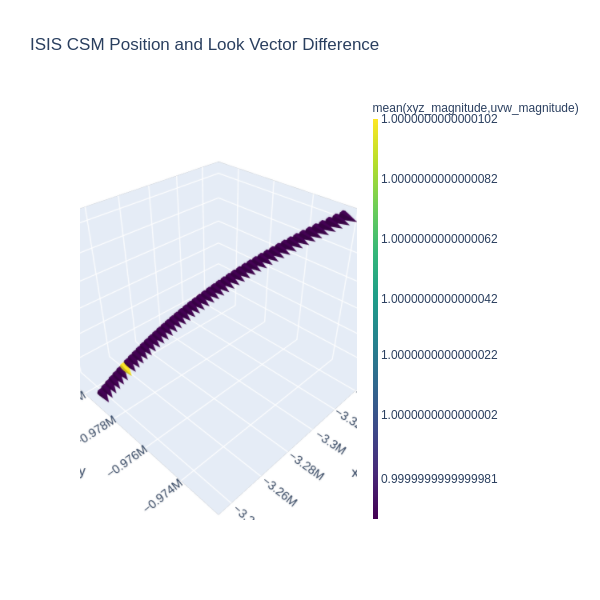

In [6]:
csmisis_diff_lv_plot_bytes = csmisis_diff_lv_plot.to_image(format="png")
Image(csmisis_diff_lv_plot_bytes)

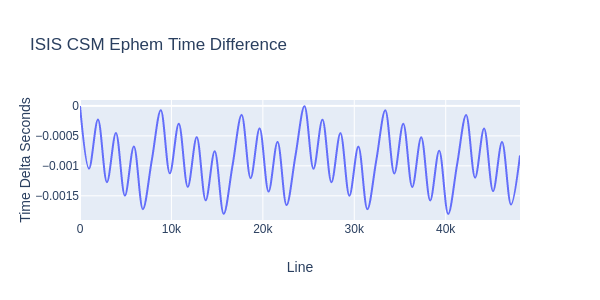

In [7]:
csmisis_diff_ephem_plot_bytes = csmisis_diff_ephem_plot.to_image(format="png")
Image(csmisis_diff_ephem_plot_bytes)

In [8]:
external_orientation_data[['diffx', 'diffy', 'diffz', 'diffu', 'diffv', 'diffw']].describe()

,diffx,diffy,diffz,diffu,diffv,diffw
count,500.000000,5.000000e+02,500.000000,5.000000e+02,5.000000e+02,5.000000e+02
mean,1.123216,-5.189858e-02,-2.897784,-3.703806e-06,1.811224e-07,9.746793e-06
std,0.678320,4.245232e-02,1.744070,2.233894e-06,2.229106e-07,5.880587e-06
min,-0.000548,-1.634247e-01,-5.850461,-7.771770e-06,-2.506653e-07,-4.163336e-15
25%,0.553210,-8.063833e-02,-4.377793,-5.734157e-06,8.989063e-10,4.797146e-06
50%,1.109063,-4.173908e-02,-2.889143,-3.618779e-06,1.419224e-07,9.821019e-06
75%,1.739767,-1.616733e-02,-1.429555,-1.759892e-06,3.234053e-07,1.486457e-05
max,2.334375,-3.026798e-09,0.000045,1.887379e-15,6.874561e-07,1.963323e-05


In [9]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, 10, 50, 500, 500)

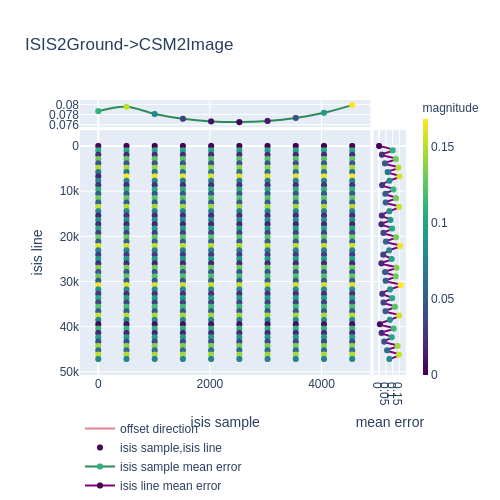

In [10]:
Image(isis2csm_plot.to_image())

In [11]:
isis2csm_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,-0.074897,0.000159
std,0.049701,0.011165
min,-0.168404,-0.032669
25%,-0.119255,-0.005536
50%,-0.076003,0.000267
75%,-0.037781,0.005991
max,0.027938,0.033640


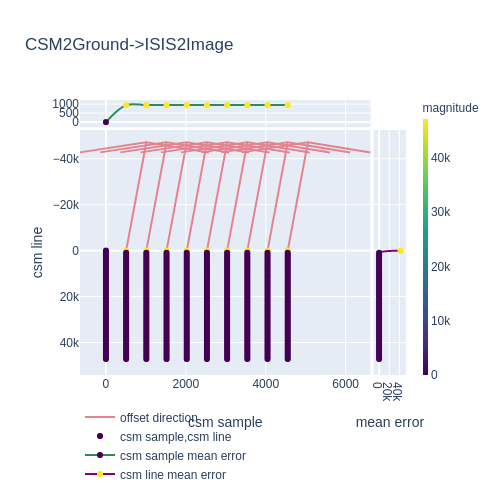

In [12]:
Image(csm2isis_plot.to_image())

In [13]:
csm2isis_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,-848.906691,9.100239
std,6276.979051,67.287707
min,-47165.377126,-0.034252
25%,0.036507,-0.007466
50%,0.067958,-0.000534
75%,0.104883,0.005558
max,0.156148,505.601789


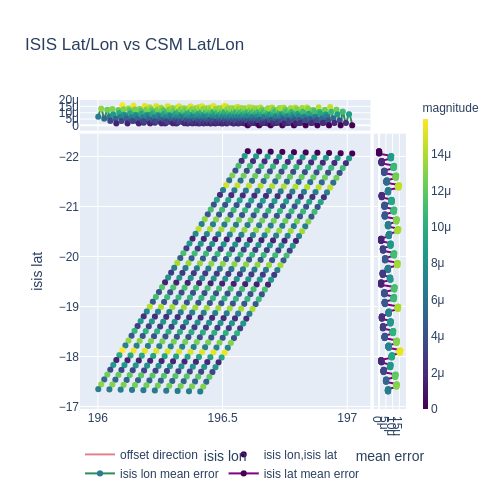

In [14]:
Image(isiscsm_plotlatlon.to_image())

In [15]:
isiscsm_latlondata[['diff lon', 'diff lat']].describe()

,diff lon,diff lat
count,5.000000e+02,500.000000
mean,9.512926e-07,-0.000007
std,1.202016e-06,0.000004
min,-1.629576e-06,-0.000016
25%,2.340794e-07,-0.000011
50%,1.026660e-06,-0.000007
75%,1.599855e-06,-0.000004
max,3.954838e-06,0.000002


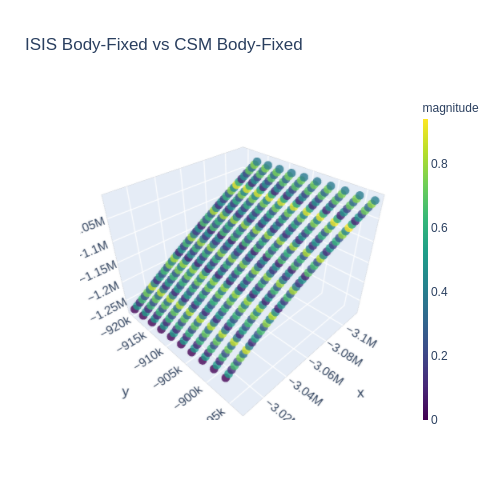

In [16]:
Image(isiscsm_plotbf.to_image())

In [17]:
isiscsm_bfdata[['diffx', 'diffy', 'diffz']].describe()

,diffx,diffy,diffz
count,500.000000,500.000000,500.000000
mean,1.456372,0.010609,0.393331
std,0.648327,0.055911,0.237967
min,-2.133110,-0.131199,-0.125057
25%,1.449544,-0.016614,0.204495
50%,1.535224,0.011376,0.379865
75%,1.624968,0.039950,0.582949
max,2.372664,0.175814,0.881954
